# Descriptors
Image Patch -- Just use the pixel values of the patch
- Perfectly fine if geometry and appearance is unchanged
- A downsampling is useful to make it simple, fast, robust to small affine transforms.

Image Gradients
- Feature is invariant to absolute intensity values
- Sensitive to deformations

Color histogram
- Invariant to changes in scale and rotation
- Sensitive to spatial layout

Spatial histograms
- Retains rough spatial layout
- Some invariance to deformations
- Orientation normalization may useful -- Use the dominant image gradient direction to normalize the orientation of the patch

#### Haar Wavelets

https://shodhganga.inflibnet.ac.in/bitstream/10603/20682/12/12_chapter%203.pdf

http://mathworld.wolfram.com/HaarFunction.html

http://www.faculty.jacobs-university.de/llinsen/teaching/320491/Lecture05.pdf

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [39]:
illidan = cv2.imread('dataset/illidan.jpg')
illidan = cv2.resize(illidan, (512, 512))

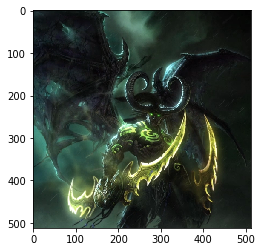

In [40]:
plt.imshow(illidan)

In [30]:
def downsampling(img, scale, gsigma = 1, ksize = None):
    if scale == 1:
        return img
    if ksize and gsigma > 0:
        img = cv2.GaussianBlur(img, ksize, gsigma)
    m = img.shape[0]
    n = img.shape[1]
    vdel = img.reshape(-1, 3)[:m // scale * scale * n // scale * scale, :].reshape((-1, scale, 3))[:,0,:]
    return vdel.reshape((m // scale, -1, 3))[:, : n//scale, :]

In [96]:
def haar_wavelets_base(img, scale, base):
    if scale == 1:
        base['bottomleft'] = img
        return img / 255
    
    output = np.zeros_like(img, dtype = float)
    
    m = img.shape[0] // 2
    n = img.shape[1] // 2
    
    topleft = np.array([[-1, -1], [1, 1]]) / 2
    topright = np.array([[-1, 1],[1, -1]]) / 2
    bottomleft = np.array([[1, 1], [1, 1]]) / 2
    bottomright = np.array([[1, -1], [1, -1]]) / 2
    
    base['bottomleft'] = {}
    output[m:, :n, :] = haar_wavelets_base(downsampling(cv2.filter2D(img, cv2.CV_32F, bottomleft), 2), scale - 1, base['bottomleft'])
    base['topleft'] = output[:m, :n, :] = downsampling(cv2.filter2D(img, cv2.CV_32F, topleft), 2)
    base['topright'] = output[:m, n:, :] = downsampling(cv2.filter2D(img, cv2.CV_32F, topright), 2)
    base['bottomright'] = output[m:, n:, :] = downsampling(cv2.filter2D(img, cv2.CV_32F, bottomright), 2)
    
    return output
    

In [97]:
base = {}
scale = 3
haar = haar_wavelets_base(illidan, scale, base)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


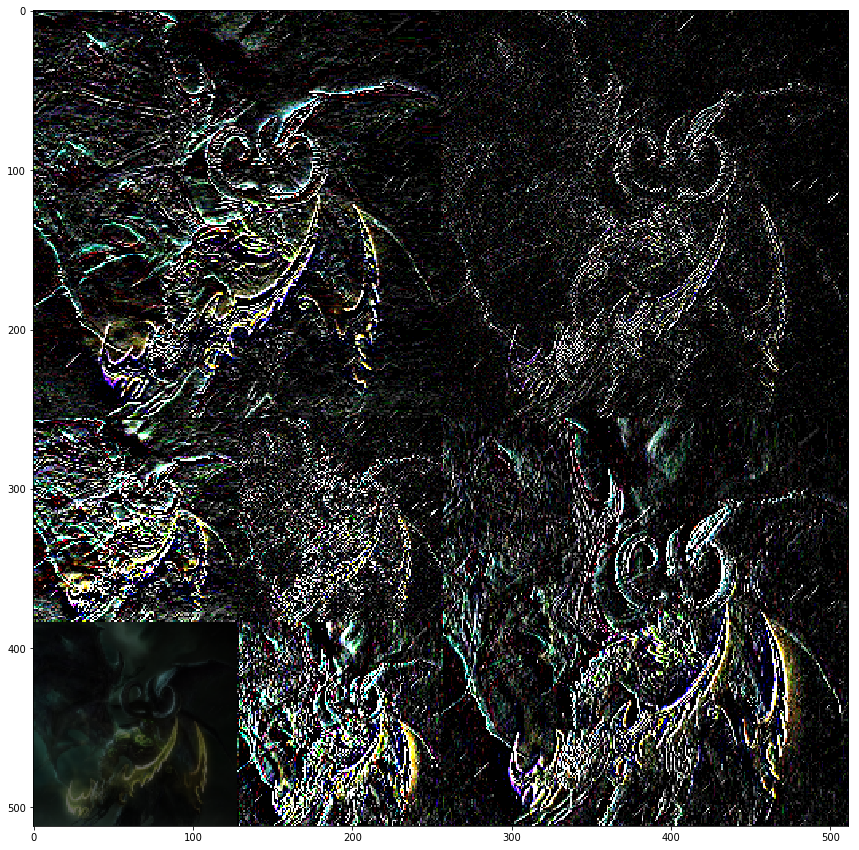

In [104]:
fig = plt.figure(figsize = (15, 15))
plt.imshow(haar / 10)

In [99]:
def examineEnergy(haarDict, output):
    for k, v in haarDict.items():
        if isinstance(v, dict):
            examineEnergy(v, output)
        else:
            output.append(np.sum(v ** 2))

In [100]:
output = []
examineEnergy(base, output)
output[0] = output[0] * 255

In [102]:
output

[755379555840.0,
 23412536.0,
 8316310.5,
 47475864.0,
 13751153.0,
 3615532.8,
 26689954.0]

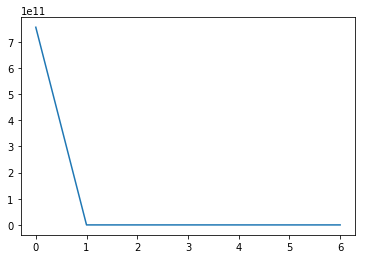

In [101]:
plt.plot(output)

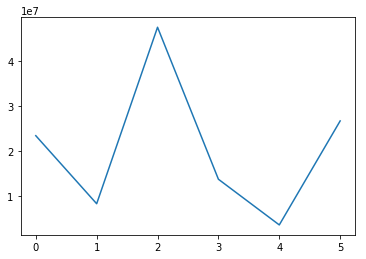

In [103]:
plt.plot(output[1:])

Multi-Scale Oriented Patches 